# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

np.random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# Load Preprocessed Data

In [2]:
data = pd.read_csv('train_data_preprocessed_with_outliers_and_imba.csv') 
# all data here is training data - test data is elsewhere
data

,id,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15,recent_sells,beds_4more,has_basement,loc_north_west,loc_north_east
0,7739100155,750000,1.75,2850,11860,1.0,0,0,3,9,2850,1951,0,2640,11604,0,1,0,1,0
1,6099400053,145000,1.00,1010,5490,1.0,0,0,3,6,1010,1954,0,1740,10658,0,0,0,0,0
2,7468900270,140000,1.00,1090,10114,1.0,0,0,4,7,1090,1955,0,1380,7800,0,0,0,0,0
3,396100025,339999,2.00,1740,6369,1.0,0,0,5,6,870,1954,0,1560,7200,0,1,1,1,0
4,1160000255,311000,1.00,1120,8631,1.0,0,0,3,7,1120,1942,0,1350,7714,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18228,5272200045,378000,1.50,1000,6914,1.0,0,0,3,7,1000,1947,0,1000,6947,1,0,0,1,0
18229,9578500790,399950,2.50,3087,5002,2.0,0,0,3,8,3087,2014,0,2927,5183,1,0,0,0,0
18230,7202350480,575000,2.50,2120,4780,2.0,0,0,3,7,2120,2004,0,1690,2650,0,0,0,0,1
18231,1723049033,245000,0.75,380,15000,1.0,0,0,3,5,380,1963,0,1170,15000,0,0,0,0,0


In [3]:
df = data.drop(['id'], axis = 1)
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

X = np.array(X, dtype = 'int64')

## Split and scale

In [4]:
X_train, X_val = train_test_split(X, test_size = 0.15, random_state = 42) 
y_train, y_val = train_test_split(y, test_size = 0.15, random_state = 42) 

In [5]:
X_train.shape

(15498, 18)

In [6]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [7]:
X_train.shape

(15498, 18)

# Modeling

In [8]:
def prepare_sets(X,y):
    N = len(X)
    X_b = np.c_[np.ones((N, 1)), X]    
    y_ = np.array(y).reshape(-1,1)
    
    return X_b, y_     

In [9]:
X_train, y_train = prepare_sets(X_train, y_train)
X_val, y_val = prepare_sets(X_val, y_val)

## Linear Regression with Normal Equation

**Normal Equation:**

$\hat{\theta} = (X^T X)^{-1} X^T y$

In [10]:
class LinearRegression():
    def __init__(self):
        return None
    
    def fit(self, X, y):        
        self.theta = np.linalg.inv((X.T.dot(X))).dot(X.T.dot(y))
        
        return self.theta
    
    def predict(self, X):
        return X.dot(self.theta)

In [11]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_val)

Wall time: 13.3 ms


In [12]:
lin_r2 = r2_score(y_val, y_pred_lin)
lin_r2

0.7225927050639889

# Gradient Descent

In [13]:
ETA = 0.005 #learning rate
EPOCHS = 500

## Linear Regression with Batch Gradient Descent

In [14]:
np.random.seed(42)

In [15]:
class BatchGDLinearRegression():
    def __init__(self, learning_rate=0.01, epochs = 100):
        self.learning_rate, self.epochs = learning_rate, epochs
    
    def fit(self, X, y):
        theta_path_bgd = []
        gradient_path_bgd = []
      
        N = len(X)   
        n_inputs = X.shape[1]
        n_outputs = 1
      
        self.theta = np.random.randn(n_inputs, n_outputs)
        
        for epoch in range(self.epochs):
            y_pred = X.dot(theta)
            gradients = 2/N * X.T.dot(y_pred - y) #gradient of cost function
            self.theta = self.theta - self.learning_rate * gradients
            
            gradient_path_bgd.append(gradients)
            theta_path_bgd.append(self.theta)
                
              
        return theta_path_bgd, self.theta
    
    def predict(self, X):
        return X.dot(self.theta)

In [16]:
%%time

bgd_lr = BatchGDLinearRegression(learning_rate = ETA, epochs = EPOCHS)
theta_path_bgd, theta_bgd = bgd_lr.fit(X_train, y_train)
y_pred_bgd = bgd_lr.predict(X_val)

Wall time: 97.3 ms


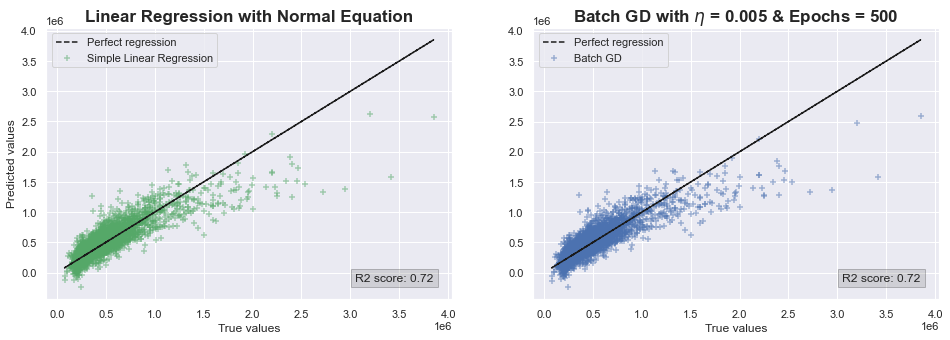

In [17]:
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.scatter(y_val, y_pred_lin, label = 'Simple Linear Regression', color = 'g', marker = '+', alpha = 0.5)
plt.plot(y_val, y_val, 'k--', label = 'Perfect regression')

plt.text(y_val.max()-800000,y_pred_lin.min()+100000,'R2 score: {:.2f}'.format(r2_score(y_val, y_pred_lin)), 
         bbox=dict(facecolor='grey', edgecolor = 'k', alpha=0.25))

plt.title('Linear Regression with Normal Equation', weight = 'bold', size = 17)
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')

plt.subplot(122)
plt.scatter(x = y_val, y = y_pred_bgd, color = 'b', marker = '+', label = 'Batch GD', alpha = 0.5)
plt.plot(y_val, y_val, 'k--', label = 'Perfect regression')
plt.text(y_val.max()-800000,y_pred_bgd.min()+100000,'R2 score: {:.2f}'.format(r2_score(y_val, y_pred_bgd)), 
         bbox=dict(facecolor='grey', edgecolor = 'k', alpha=0.25))
plt.xlabel('True values')
plt.legend()

plt.title(r'Batch GD with $\eta$ = 0.005 & Epochs = 500', weight = 'bold', size = 17)
plt.show()

## Stochastic GD LinReg

In [18]:
class StochasticGDLinearRegression():
    def __init__(self, learning_rate=0.001, decay = 0.001/100, n_epochs=100):
        self.learning_rate,  self.decay,    = learning_rate, decay
        self.n_epochs = n_epochs
    
    def time_based_learning_schedule(self, t):
        return self.learning_rate / (1 + self.decay * t)
    
    def fit(self, X, y): #fit model on train sets to find optimal theta & return theta_path
        theta_path_sgd = []   
        learning_rate_path = []
        
        N = len(X)      
        n_inputs = X.shape[1]
        n_outputs = 1
        
        self.theta = np.random.randn(n_inputs, n_outputs)
        
        for epoch in range(self.n_epochs):
            self.learning_rate = self.time_based_learning_schedule(epoch)
            
            for i in range(N):
                random_index = np.random.randint(N)
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]
                
                yi_pred = xi.dot(self.theta)
                gradients = 2 * xi.T.dot(yi_pred - yi)
                self.theta = self.theta - self.learning_rate * gradients
            
            learning_rate_path.append(self.learning_rate)
            theta_path_sgd.append(self.theta)
                                
                
        return theta_path_sgd, self.theta, learning_rate_path

    def predict(self, X):
        return X.dot(self.theta)

In [19]:
#ETA = 0.005
EPOCHS = 20

In [20]:
%%time
np.random.seed(42)
sgd_lr = StochasticGDLinearRegression(learning_rate=ETA, decay = 0.05, n_epochs=EPOCHS)
theta_path_sgd, theta_sgd, learning_rate_path_sgd = sgd_lr.fit(X_train, y_train)
y_pred_s = sgd_lr.predict(X_val)
r2_score(y_val, y_pred_s)

Wall time: 4.38 s


0.7222836085603603

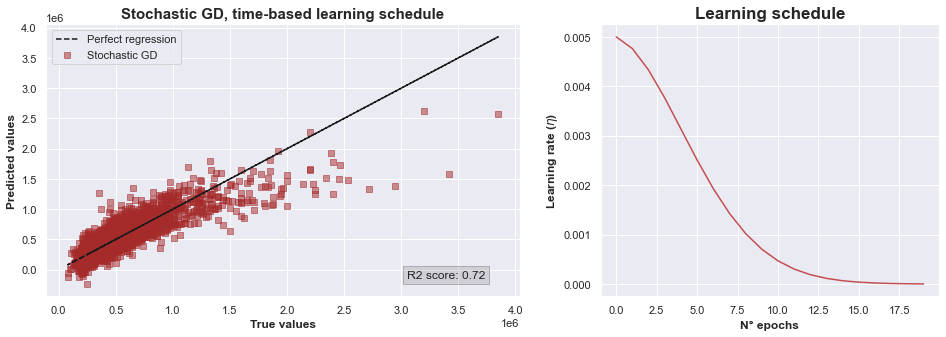

In [21]:
fig, axs = plt.subplots(ncols = 2, gridspec_kw=dict(width_ratios=[7,5]), figsize =(16,5))

axs[0].set_title('Stochastic GD, time-based learning schedule', weight = 'bold', size = 15)
axs[0].scatter(x = y_val, y = y_pred_s, c = 'brown', alpha = 0.5, marker = 's', label = 'Stochastic GD'), 
axs[0].plot(y_val, y_val, 'k--', label = 'Perfect regression')
axs[0].set_ylabel('Predicted values', weight = 'bold', size = 12)
axs[0].text(y_val.max()-800000,y_pred_s.min()+100000,'R2 score: {:.2f}'.format(r2_score(y_val, y_pred_s)), 
         bbox=dict(facecolor='grey', edgecolor = 'k', alpha=0.25))
axs[0].set_xlabel('True values', weight = 'bold', size = 12)
axs[0].legend()


axs[1].plot(learning_rate_path_sgd, c = 'r')
axs[1].set_title('Learning schedule', weight = 'bold', size = 17)
axs[1].set_ylabel(r'Learning rate ($\eta$)', weight = 'bold', size = 12)
axs[1].set_xlabel('N° epochs', weight = 'bold', size = 12)
plt.show()

## Mini-Batch GD Linear Regression

In [22]:
class MiniBatchGDLinearRegression():
    def __init__(self, learning_rate=0.01, decay = 0.001, n_epochs=100, minibatch_size = 32):
        self.learning_rate,  self.decay,    = learning_rate, decay
        self.n_epochs = n_epochs
        self.minibatch_size = minibatch_size
    
    def time_based_learning_schedule(self, t):
        return self.learning_rate / (1 + self.decay * t)
    
    def fit(self, X, y):
        theta_path_mbgd = []
        gradient_path_mbgd = []
      
        N = len(X)   
        n_inputs = X.shape[1]
        n_outputs = 1
      
        self.theta = np.random.randn(n_inputs, n_outputs)
               
        for epoch in range(self.n_epochs):
            shuffled_indices = np.random.permutation(N)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]   
            
            self.learning_rate = self.time_based_learning_schedule(epoch)
            
            for i in range(0, N, self.minibatch_size):
                xi = X_shuffled[i:i+self.minibatch_size]
                yi = y_shuffled[i:i+self.minibatch_size]
                
                yi_pred = xi.dot(self.theta)
                gradients = 2/self.minibatch_size * xi.T.dot(yi_pred - yi)
                self.theta = self.theta - self.learning_rate * gradients
            
            gradient_path_mbgd.append(gradients)
            theta_path_mbgd.append(self.theta)
                
               
        return theta_path_mbgd, self.theta

    def predict(self, X):
        return X.dot(self.theta)

In [23]:
np.random.seed(42)

In [24]:
%%time
mbgd_lr = MiniBatchGDLinearRegression(learning_rate=ETA, decay = 0.1/EPOCHS, n_epochs=EPOCHS, minibatch_size = 32)
theta_path_mbgd, theta_mbgd = mbgd_lr.fit(X_train, y_train)
y_pred_mb = mbgd_lr.predict(X_val)

Wall time: 117 ms


In [25]:
%%time
mbgd_lr1 = MiniBatchGDLinearRegression(learning_rate=ETA, decay = 0.1/EPOCHS, n_epochs=EPOCHS, minibatch_size = 256)
theta_path_mbgd, theta_mbgd = mbgd_lr1.fit(X_train, y_train)
y_pred_mb1 = mbgd_lr1.predict(X_val)
r2_score(y_val, y_pred_mb1)

Wall time: 59 ms


0.7241917889936696

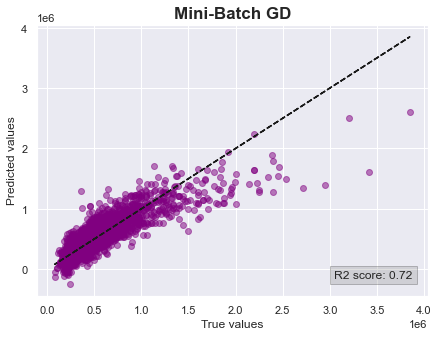

In [26]:
plt.figure(figsize = (7,5))

plt.scatter(x = y_val, y = y_pred_mb1, color = 'purple', marker = 'o', label = 'MiniBatch GD', alpha = 0.5)
plt.plot(y_val, y_val, 'k--', label = 'Perfect regression')
plt.text(y_val.max()-800000,y_pred_mb1.min()+100000,'R2 score: {:.2f}'.format(r2_score(y_val, y_pred_mb1)), 
         bbox=dict(facecolor='grey', edgecolor = 'k', alpha=0.25))
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Mini-Batch GD', weight = 'bold', size = 17)
plt.show()

## Viz recap

In [27]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mbgd = np.array(theta_path_mbgd)

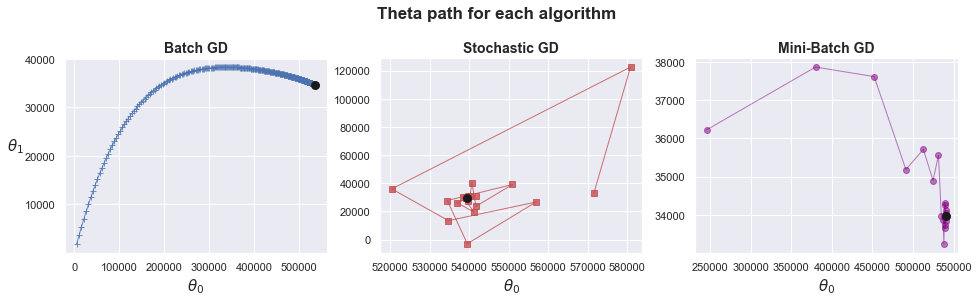

In [28]:
fig, axs = plt.subplots(ncols = 3, figsize = (16,4))

axs[0].plot(theta_path_bgd[0:, 0], theta_path_bgd[0:, 1], "b-+", linewidth=1, label="Batch", alpha = 0.8, zorder = 1)
axs[0].scatter(x= theta_bgd[0],y=theta_bgd[1], color = 'k', linewidth = 3, zorder = 2)
axs[0].set_ylabel(r"$\theta_1$   ", fontsize=15, rotation=0)
axs[0].set_xlabel(r"$\theta_0$", fontsize=15)
axs[0].set_title('Batch GD', weight = 'bold', size = 14)


axs[1].plot(theta_path_sgd[0:, 0], theta_path_sgd[0:, 1], "r-s", linewidth=1, label="Stochastic", alpha = 0.8, zorder = 1)
axs[1].scatter(x= theta_sgd[0],y=theta_sgd[1], color = 'k', linewidth = 3, zorder = 2)
axs[1].set_xlabel(r"$\theta_0$", fontsize=15)
axs[1].set_title('Stochastic GD', weight = 'bold', size = 14)


axs[2].plot(theta_path_mbgd[0:, 0], theta_path_mbgd[0:, 1], "purple", marker = 'o', linewidth=1, label="Mini-batch", zorder = 1, alpha = 0.5)
axs[2].scatter(x= theta_mbgd[0],y=theta_mbgd[1], color = 'k', linewidth = 3, zorder = 2)
axs[2].set_xlabel(r"$\theta_0$", fontsize=15)
axs[2].set_title('Mini-Batch GD', weight = 'bold', size = 14)

fig.suptitle('Theta path for each algorithm', size = 17, weight = 'bold')
fig.subplots_adjust(top=0.8)

plt.show()